In [1]:
#python -m pip install qiskit qiskit_aer matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la


from qiskit import QuantumCircuit, transpile
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.primitives import StatevectorEstimator, BackendEstimatorV2 as BackendEstimator
from qiskit_ibm_runtime import QiskitRuntimeService
 


from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.primitives import EstimatorV2 as Estimator


Si simulerà il sistema fisico descritto dall'hamiltoniana della XXX-Heisenberg Chain 
$$
\begin{equation}
H_{\text{Heis}} = \sum_{\langle ij \rangle}^{N} J \left(\sigma_x^{(i)}\sigma_x^{(j)} + \sigma_y^{(i)}\sigma_y^{(j)} + \sigma_z^{(i)}\sigma_z^{(j)}\right).
\end{equation}
$$
tramite trotterization di U(t), operatore d'evoluzione temporale.

## A,B) Simulazione su un sistema a 2 qubit 

In [3]:
#definiamo l'hamiltoniana
def H_Heis(N):
    #usiamo J = 1
    XX_tuples = [("XX", [i, i + 1], 1) for i in range(0, N-1)]
    YY_tuples = [("YY", [i, i + 1], 1) for i in range(0, N-1)]
    ZZ_tuples = [("ZZ", [i, i + 1], 1) for i in range(0, N-1)]

    #col metodo from_sparse_list di SparsePauliOp definiamo l'hamiltoniana
    hamiltonian = SparsePauliOp.from_sparse_list([*XX_tuples, *YY_tuples, *ZZ_tuples], N)

    return hamiltonian

In [4]:
#definiamo l'evoluzione temporale nel caso classico
def U_Heis(n_spins,t):
    H = H_Heis(n_spins).to_matrix()
    return la.expm(-1j*t*H)

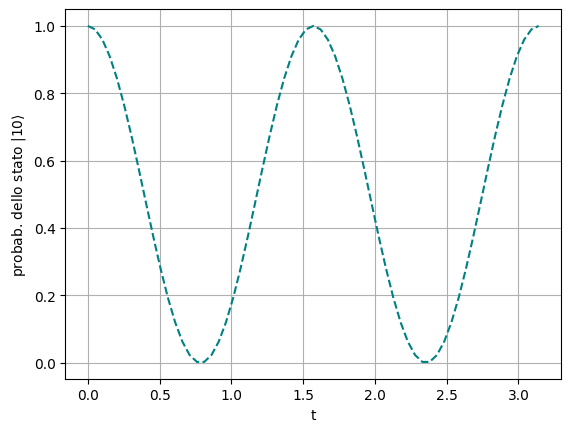

In [5]:
#definiamo il numero di time steps
t_steps = 63

#definiamo il tempo in cui facciamo evolvere il sistema
dt = np.pi

#generiamo una spaziatura lineare di t_steps nell'intervallo [0, pi]
ts = np.linspace(0, dt, t_steps) 

#definiamo lo stato iniziale che vogliamo prendere in esame, ovvero 10, tramite uno StateVector
initial_state = Statevector.from_label('01').data

#computiamo la probabilità di rimanere nello stato 10 in seguito ad una evoluzione
# @ è abbreviazione per il prodotto interno. ne facciamo il modulo quadro per ricavare la probabilità. 
probs_10_classical = [np.abs((initial_state @ U_Heis(2,float(t)) @ initial_state))**2 for t in ts]

#plottiamo il grafico di probs_10_classical come f(t)
plt.plot(ts, probs_10_classical,linestyle="dashed",color="teal")
plt.xlabel('t')
plt.ylabel(r"probab. dello stato $|10\rangle$")
#plt.title(r"Simulazione classica dell'evoluzione dello stato $|10\rangle$")
plt.savefig('../png/10_classical.png')
plt.grid()
plt.show()

L'Hamiltoniana è scritta come somma di interazioni locali, pertanto è possibile applicare l'operatore di evoluzione temporale come segue (come spiegato nel Nielsen, Chuang), implementando la formula di Trotter, che introduce un errore di $O(t^2)$

$e^{i(A+B)t} = e^{iAt}e^{iBt}$

dunque nel caso in esame 
$$
\begin{align}
U_{\text{Heis}}(t) &= \exp\left(-it\sigma_x^{(0)}\sigma_x^{(1)}\right) \exp\left(-it\sigma_y^{(0)}\sigma_y^{(1)}\right) \exp\left(-it\sigma_z^{(0)}\sigma_z^{(1)}\right) 
\end{align}
$$

Andiamo ad implementare la decomposizione dell'esponenziale tramite rotazioni con gate che agiscono sui singoli qubit e l'ausilio di gate CNOT, sapendo che in generale vale che
$$
\begin{align}
e^{-itX} = R_{X} (2t)
\end{align}
$$

Iniziamo dalla rotazione ZZ, ovvero $R_{zz}(\theta)$. Di base su 1 qubit (matrice 2x2)
\begin{equation} R_Z(\theta) = cos(\theta) \cdot I - isin(\theta) \cdot Z= \begin{bmatrix}
cos(\theta) - isin(\theta) & 0 \\
0 & cos(\theta) + isin(\theta) 
\end{bmatrix} \end{equation}
e il CNOT gate, che agisce su 2 qubit (matrice 4x4)
\begin{equation}
CNOT = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0 
\end{bmatrix} 
\end{equation}
Vogliamo arrivare a 
$$
R_{ZZ}(\theta) = \cos(\theta) I \otimes I - i\sin(\theta) Z \otimes Z = 
\begin{bmatrix}
\cos(\theta)- i\sin(\theta) & 0 & 0 & 0 \\
0 & \cos(\theta)+ i\sin(\theta) & 0 & 0 \\
0 & 0 & \cos(\theta)+ i\sin(\theta) & 0 \\
0 & 0 & 0 & \cos(\theta)- i\sin(\theta)
\end{bmatrix}
$$

Dunque partiamo da $I \otimes R_Z(\theta)$ e switchiamo gli elementi in terza e quarta posizione sulla diagonale tramite due CNOT, in modo tale che $R_{ZZ}(\theta) = CNOT_{12}*I \otimes R_{Z}(\theta)*CNOT_{12}$


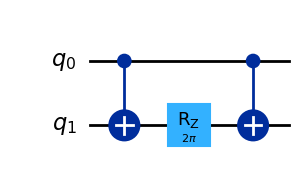

In [6]:
#decomponiamo il Rot. Gate ZZ, lo implementiamo come una funzione che restituisce un circuito con implementati i gate 
def R_zz(t):
    
    ZZ_qc = QuantumCircuit(2)

    ZZ_qc.cx(0,1)
    ZZ_qc.rz(2 * t, 1) #vedi definizione sopracitata per il fattore 2
    ZZ_qc.cx(0,1)

    return ZZ_qc
    
R_zz(dt).draw(output='mpl', filename='../circuit_drawing/RZZ.png')

$R_{XX}$ e $R_{YY}$ non sono diagonali sulla base computazionale, pertanto effettuiamo un cambio di base, utilizziamo $R_{ZZ}$ e otteniamo così i due operatori cercati.

Per $R_{XX}$ usiamo che 
\begin{equation}
R_Y (\frac{\pi}{2}) \cdot Z \cdot R_Y (-\frac{\pi}{2})
\end{equation}

\begin{equation}
 R_Y (\frac{\pi}{2})\cdot R_Y (-\frac{\pi}{2}) = I
\end{equation}

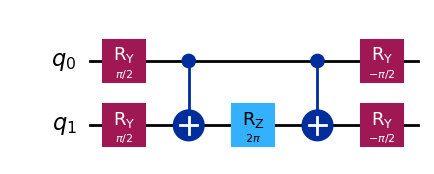

In [7]:
#decomponiamo il Rot. Gate XX
def R_xx(t):

    XX_qc = QuantumCircuit(2)

    XX_qc.ry(np.pi/2,[0,1])
    XX_qc.cx(0,1)
    XX_qc.rz(2 * t, 1)
    XX_qc.cx(0,1)
    XX_qc.ry(-np.pi/2,[0,1])

    return XX_qc

R_xx(dt).draw(output='mpl', filename='../circuit_drawing/RXX.png')

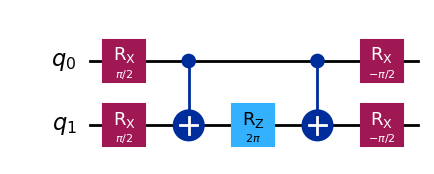

In [8]:
#decomponiamo il Rot. Gate YY
def R_yy(t):
    YY_qc = QuantumCircuit(2)
    
    YY_qc.rx(np.pi/2,[0,1])
    YY_qc.cx(0,1)
    YY_qc.rz(2 * t, 1)
    YY_qc.cx(0,1)
    YY_qc.rx(-np.pi/2,[0,1])

    return YY_qc

R_yy(dt).draw(output='mpl', filename='../circuit_drawing/RYY.png')

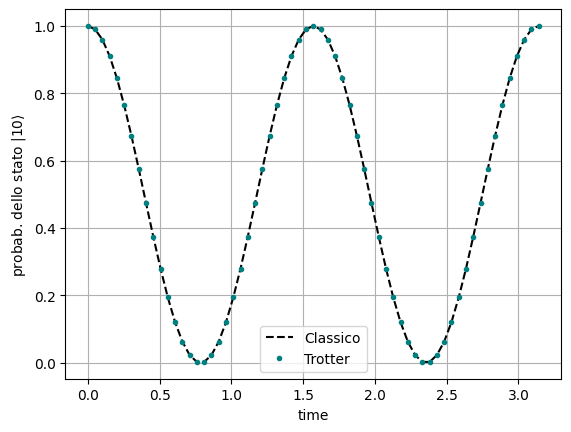

In [9]:
#definiamo gli estimator
exact_estimator = StatevectorEstimator()
pm = generate_preset_pass_manager(optimization_level=0)


#vogliamo misurare |10><10|, dunque ci serve |0><0| e |1><1|.
#|0><0|= (1/2)*(I+Z)
#|1><1|= (1/2)*(I-Z)
prj = SparsePauliOp.from_list([("II", 1/4), ("ZZ", -1/4), ("ZI",-1/4), ("IZ",1/4)])

#dove depositare i risultati
probs_10    = []

#simuliamo
for sim_t in ts:
    
    # #prepariamo lo stato 10 costruendo il circuito e applicando un x-gate sul primo qubit 
    qc = QuantumCircuit(2)
    qc.x(1)
    qc = qc.compose(R_xx(sim_t))
    qc = qc.compose(R_yy(sim_t))
    qc = qc.compose(R_zz(sim_t))

    #misuriamo exact
    isa_circuit = pm.run(qc)
    isa_observable = prj.apply_layout(isa_circuit.layout)
    result = exact_estimator.run([(isa_circuit, isa_observable)]).result()
    values = result[0].data.evs
    probs_10.append(values)


#plottiamo
plt.plot(ts, probs_10_classical,linestyle="dashed",color="black",label="Classico")
plt.plot(ts, probs_10,color="teal",label="Trotter",linestyle="",marker=".")
plt.xlabel('time')
plt.ylabel(r"probab. dello stato $|10\rangle$")
plt.savefig('../png/10_trotter.png')
plt.legend()
plt.grid()
plt.show()
    

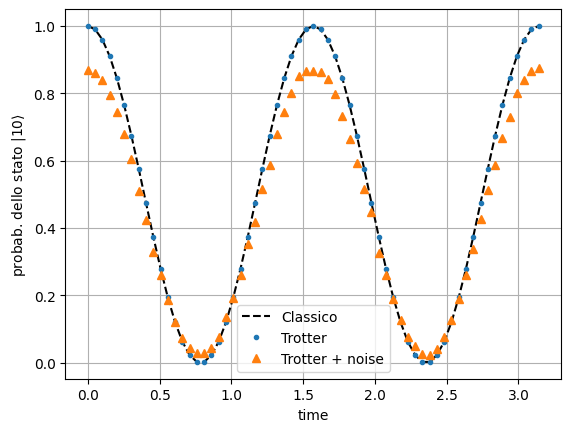

In [10]:
from qiskit_ibm_runtime.fake_provider import FakeManilaV2, FakeMontrealV2
QiskitRuntimeService.save_account(channel="ibm_quantum", token="982082508a1c98ca02cb712c6751b42ef860d905b080b3bfc02ef35d68d84441803586912cbcf181e1e72ebc8569103421b06c25408fe8134975a72575c4d637", overwrite= True)


service = QiskitRuntimeService()
fake_backend = FakeMontrealV2()
pm = generate_preset_pass_manager(optimization_level=0, backend = fake_backend)
estimator = BackendEstimator(backend = fake_backend)

#vogliamo misurare |10><10|, dunque ci serve |0><0| e |1><1|.
#|0><0|= (1/2)*(I+Z)
#|1><1|= (1/2)*(I-Z)
prj = SparsePauliOp.from_list([("II", 1/4), ("ZZ", -1/4), ("ZI",-1/4), ("IZ",1/4)])

#dove depositare i risultati
probs_10_noisy = []

#simuliamo
for sim_t in ts:
    
    # #prepariamo lo stato 10 costruendo il circuito e applicando un x-gate sul primo qubit 
    qc = QuantumCircuit(2)
    qc.x(1)
    qc = qc.compose(R_xx(sim_t))
    qc = qc.compose(R_yy(sim_t))
    qc = qc.compose(R_zz(sim_t))

    #misuriamo noisy
    isa_noisy_circuit = pm.run(qc)
    isa_noisy_observable = prj.apply_layout(isa_noisy_circuit.layout)
    noisy_result = estimator.run([(isa_noisy_circuit, isa_noisy_observable)]).result()
    n_values = noisy_result[0].data.evs
    probs_10_noisy.append(n_values)


#plottiamo
plt.plot(ts, probs_10_classical,linestyle="dashed",color="black",label="Classico")
plt.plot(ts, probs_10,color="C0",label="Trotter",linestyle="",marker=".")
plt.plot(ts, probs_10_noisy,color="C1",label="Trotter + noise",linestyle="",marker="^")
plt.xlabel('time')
plt.ylabel(r"probab. dello stato $|10\rangle$")

plt.legend()
plt.grid()
plt.savefig('../png/10_trotternoisy.png')
plt.show()
    

## C) N_SPINS > 2

Nel caso con più di due spin, $U_{N_{SPIN}}$ non può essere direttamente decomposta in un prodotto di esponenziali, pertanto si può proseguire ad approssimarla tramite Trotter. Il passaggio fondamentale è quello di scrivere l'interazione globale tra gli spins come somma di contributi locali dati dall'interazione tra due spin vicini, ovvero ricondursi ad una somma di hamiltoniane del tipo trattato sopra, ovvero $H_2$, dunque a due spin. 
E' esemplificativo trattare il caso con $N_{SPIN} = 3$, dove possiamo scrivere $U_3$ come somma di due $H_2$ tra le due coppie di spin come segue
\begin{equation}
    U_{3} = exp[-it(H_{2}^{(0,1)} + H_{2}^{1,2})] 
\end{equation}
siccome i due operatori non commutano, non si può decomporre l'esponenziale, ovvero
\begin{equation}
    U_{3} \neq exp[-itH_{2}^{(0,1)}] \cdot exp[-itH_{2}^{(1,2)}]      
\end{equation}

Per applicare Trotter, ipotizziamo che $U_3$ è uguale ad una piccola evoluzione temporale di $H_{2}^{(0,1)}$ per un tempo $dt = \frac{t}{n}$ dove n è il numero di step, seguita da una evoluzione temporale della stessa durata di $H_{2}^{(1,2)}$, così facendo

\begin{equation}
    U_{3} \approx \{exp[-i\frac{t}{n}H_{2}^{(0,1)}] \cdot exp[-i\frac{t}{n}H_{2}^{(1,2)}]\}^n      
\end{equation}

In questo modo la generalizzazione a $N_{SPIN}$ avviene come 
\begin{equation}
    U_{N_{SPIN}} \approx \{\prod_{i = 0}^{N_{SPIN} - 1} exp[-i\frac{t}{n}H_{2}^{(i,i+1)}]\}^n      
\end{equation}
L'implementazione di Trotter per un $N_{SPIN}$ richiede $[6\cdot(N_{SPIN} -1)$} CNOT gate.

Andiamo ad introdurre nel codice una funzione Heisenberg_trotter che restituisca un QuantumCircuit con il sistema di gate che implementi la trotterization per un sistema di $N_{SPIN}$ con trotter_steps per un tempo "t". 

In [11]:
def R_zz(N, t, j, i):
    
    ZZ_qc = QuantumCircuit(N)

    ZZ_qc.cx(j,i)
    ZZ_qc.rz(2 * t, i) #vedi definizione sopracitata per il fattore 2
    ZZ_qc.cx(j,i)

    return ZZ_qc

#decomponiamo il Rot. Gate XX
def R_xx(N, t, j, i):

    XX_qc = QuantumCircuit(N)

    XX_qc.ry(np.pi/2,[j,i])
    XX_qc.cx(j,i)
    XX_qc.rz(2 * t, i)
    XX_qc.cx(j,i)
    XX_qc.ry(-np.pi/2,[j,i])

    return XX_qc

#decomponiamo il Rot. Gate YY
def R_yy(N, t, j, i):
    YY_qc = QuantumCircuit(N)
    
    YY_qc.rx(np.pi/2,[j,i])
    YY_qc.cx(j,i)
    YY_qc.rz(2 * t, i)
    YY_qc.cx(j,i)
    YY_qc.rx(-np.pi/2,[j,i])

    return YY_qc

In [12]:
def Heisenberg_Trotter(num_spins, trotter_steps, t):
    #definiamo un time step dt
    dt = (t)/(trotter_steps) 

    #creiamo il quantumcircuit
    qc_t = QuantumCircuit(num_spins)

    #iteriamo su ogni time step
    for i in range(trotter_steps):
        #iteriamo su ogni spin
        for j in range(0, num_spins -1):
            #implementazione dei gate è uguale al caso precedente, in quanto operiamo su coppie di spin
            qc_t = qc_t.compose(R_xx(num_spins,dt,j,j+1))
            qc_t = qc_t.compose(R_yy(num_spins,dt,j,j+1))
            qc_t = qc_t.compose(R_zz(num_spins,dt,j,j+1))

    return qc_t

## D,E) Simulazione su un sistema a 3 qubit 

Utilizziamo la funzione per studiare un sistema a 3 spin e computare la probabilità di rimanere nello stato 110 con diversi trotter_step, ovvero 4,8,12 

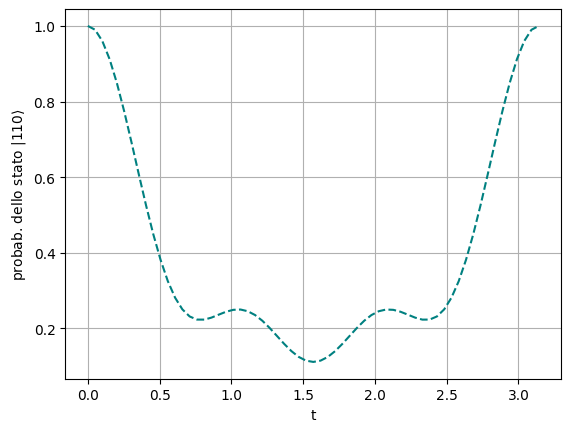

In [13]:
probs_110_trott = {4:[],8:[],12:[]}
initial_state = Statevector.from_label('011').data
probs_110 = [np.abs((initial_state @ U_Heis(3,float(t)) @ initial_state))**2 for t in ts]
#plottiamo il grafico di probs_10_classical come f(t)
plt.plot(ts, probs_110,linestyle="dashed",color="teal")
plt.xlabel('t')
plt.ylabel(r"probab. dello stato $|110\rangle$")
#plt.title(r"Simulazione classica dell'evoluzione dello stato $|10\rangle$")
plt.savefig('../png/110_classical.png')
plt.grid()
plt.show()

4 steps completed
8 steps completed
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Numero di CNOT gates: 144
Nu

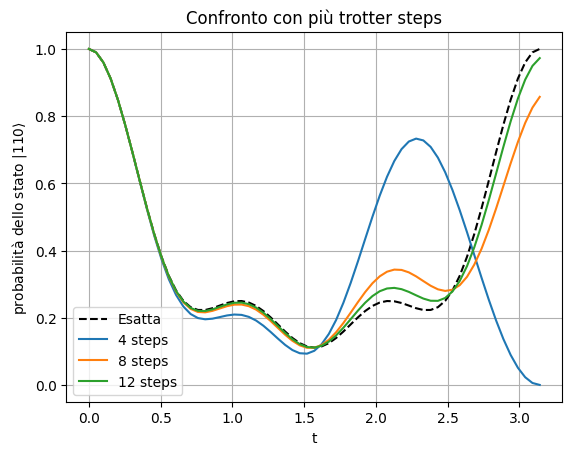

In [14]:
exact_estimator = StatevectorEstimator()
pm = generate_preset_pass_manager(optimization_level=0)

#misuriamo |110><110|
prj_zero = SparsePauliOp.from_list([("I", 1/2), ("Z", 1/2)])
prj_one = SparsePauliOp.from_list([("I", 1/2), ("Z", -1/2)])
prj = prj_one ^ prj_one ^ prj_zero



#iteriamo sui differenti valori di step di trotter
for n in probs_110_trott.keys():
    #evolviamo nel tempo
    for sim_t in ts:
        qc = QuantumCircuit(3)
        #buildiamo lo stato
        qc.x(1)
        qc.x(2)
        
        trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=n,t=sim_t)
        
        qc = qc.compose(trott_steps)
    
        if(n == 12):
            op_counts = qc.count_ops()

            # Mostra il conteggio dei gate CNOT
            print("Numero di CNOT gates:", op_counts.get('cx', 0))
        
        isa_circuit = pm.run(qc)
        isa_observable = prj.apply_layout(isa_circuit.layout)
        trotter_result = exact_estimator.run([(isa_circuit, isa_observable)]).result()
        trotter_value = trotter_result[0].data.evs
        probs_110_trott[n].append(trotter_value.mean().real)
        #print(trotter_value.mean().real)
    
    print(str(n)+" steps completed")


#plottiamo
plt.plot(ts, probs_110,linestyle="dashed",color="black",label="Esatta")
for (i,n) in enumerate(probs_110_trott.keys()):
    plt.plot(ts, probs_110_trott[n],color="C"+str(i),label=str(n)+" steps")
plt.xlabel('t')
plt.ylabel(r'probabilità dello stato $|110\rangle$')
plt.title(r'Confronto con più trotter steps')
plt.legend()
plt.grid()
plt.savefig('../png/110_steps.png')
plt.show()

OrderedDict({'cx': 600, 'ry': 400, 'rx': 400, 'rz': 300, 'x': 2})
OrderedDict({'cx': 600, 'ry': 400, 'rx': 400, 'rz': 300, 'x': 2})
OrderedDict({'cx': 600, 'ry': 400, 'rx': 400, 'rz': 300, 'x': 2})
OrderedDict({'cx': 600, 'ry': 400, 'rx': 400, 'rz': 300, 'x': 2})
OrderedDict({'cx': 600, 'ry': 400, 'rx': 400, 'rz': 300, 'x': 2})
OrderedDict({'cx': 600, 'ry': 400, 'rx': 400, 'rz': 300, 'x': 2})
OrderedDict({'cx': 600, 'ry': 400, 'rx': 400, 'rz': 300, 'x': 2})
OrderedDict({'cx': 600, 'ry': 400, 'rx': 400, 'rz': 300, 'x': 2})
OrderedDict({'cx': 600, 'ry': 400, 'rx': 400, 'rz': 300, 'x': 2})
OrderedDict({'cx': 600, 'ry': 400, 'rx': 400, 'rz': 300, 'x': 2})
OrderedDict({'cx': 600, 'ry': 400, 'rx': 400, 'rz': 300, 'x': 2})
OrderedDict({'cx': 600, 'ry': 400, 'rx': 400, 'rz': 300, 'x': 2})
OrderedDict({'cx': 600, 'ry': 400, 'rx': 400, 'rz': 300, 'x': 2})
OrderedDict({'cx': 600, 'ry': 400, 'rx': 400, 'rz': 300, 'x': 2})
OrderedDict({'cx': 600, 'ry': 400, 'rx': 400, 'rz': 300, 'x': 2})
OrderedDic

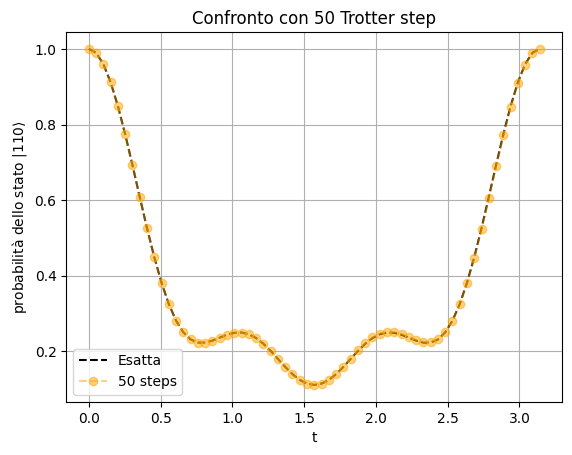

In [24]:
exact_estimator = StatevectorEstimator()
pm = generate_preset_pass_manager(optimization_level=0)

#misuriamo |110><110|
prj_zero = SparsePauliOp.from_list([("I", 1/2), ("Z", 1/2)])
prj_one = SparsePauliOp.from_list([("I", 1/2), ("Z", -1/2)])
prj = prj_one ^ prj_one ^ prj_zero

probs_110_trott = []

#evolviamo nel tempo
for sim_t in ts:
    qc = QuantumCircuit(3)
    #buildiamo lo stato
    qc.x(1)
    qc.x(2)
        
    trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=50,t=sim_t)
        
    qc = qc.compose(trott_steps)
    

    # Mostra il conteggio dei gate CNOT
    print(qc.count_ops())
        
    isa_circuit = pm.run(qc)
    isa_observable = prj.apply_layout(isa_circuit.layout)
    trotter_result = exact_estimator.run([(isa_circuit, isa_observable)]).result()
    trotter_value = trotter_result[0].data.evs
    probs_110_trott.append(trotter_value.mean().real)
        #print(trotter_value.mean().real)
    


#plottiamo
plt.plot(ts, probs_110,linestyle="dashed",color="black",label="Esatta")
plt.plot(ts, probs_110_trott,'o--', color="orange",alpha = 0.5, label="50 steps")
plt.xlabel('t')
plt.ylabel(r'probabilità dello stato $|110\rangle$')
plt.title(r'Confronto con 50 Trotter step')
plt.legend()
plt.grid()
plt.savefig('../png/110_50_steps.png')
plt.show()

4 steps completed
8 steps completed
50 steps completed


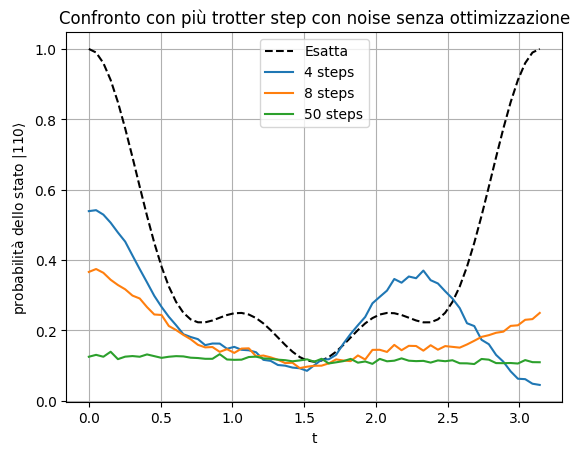

In [25]:
probs_110_trott = {4:[],8:[],50:[]}
initial_state = Statevector.from_label('011').data
probs_110 = [np.abs((initial_state @ U_Heis(3,float(t)) @ initial_state))**2 for t in ts]


estimator = BackendEstimator(backend=fake_backend)
pm = generate_preset_pass_manager(optimization_level=0, backend = fake_backend)

#misuriamo |110><110|
prj_zero = SparsePauliOp.from_list([("I", 1/2), ("Z", 1/2)])
prj_one = SparsePauliOp.from_list([("I", 1/2), ("Z", -1/2)])
prj = prj_one ^ prj_one ^ prj_zero



#iteriamo sui differenti valori di step di trotter
for n in probs_110_trott.keys():
    #evolviamo nel tempo
    for sim_t in ts:
        qc = QuantumCircuit(3)
        #buildiamo lo stato
        qc.x(1)
        qc.x(2)
        
        trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=n,t=sim_t)
        
        qc = qc.compose(trott_steps)

        isa_circuit = pm.run(qc)
        isa_observable = prj.apply_layout(isa_circuit.layout)
        trotter_result = estimator.run([(isa_circuit, isa_observable)]).result()
        trotter_value = trotter_result[0].data.evs
        probs_110_trott[n].append(trotter_value.mean().real)
        #print(trotter_value.mean().real)
    
    print(str(n)+" steps completed")


#plottiamo
plt.plot(ts, probs_110,linestyle="dashed",color="black",label="Esatta")
for (i,n) in enumerate(probs_110_trott.keys()):
    plt.plot(ts, probs_110_trott[n],color="C"+str(i),label=str(n)+" steps")
plt.xlabel('t')
plt.ylabel(r'probabilità dello stato $|110\rangle$')
plt.title(r'Confronto con più trotter step con noise senza ottimizzazione')
plt.legend()
plt.grid()
#plt.savefig('../png/110_steps_noise.png')
plt.show()

4 steps completed
8 steps completed
12 steps completed


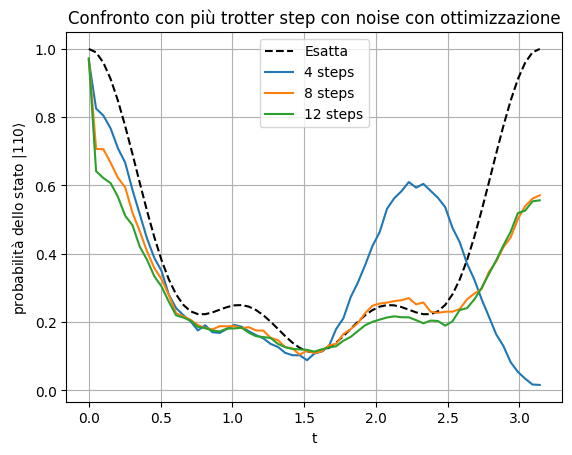

In [16]:
probs_110_trott = {4:[],8:[],12:[]}
initial_state = Statevector.from_label('011').data
probs_110 = [np.abs((initial_state @ U_Heis(3,float(t)) @ initial_state))**2 for t in ts]


estimator = BackendEstimator(backend=fake_backend)
pm = generate_preset_pass_manager(optimization_level=3, backend = fake_backend)

#misuriamo |110><110|
prj_zero = SparsePauliOp.from_list([("I", 1/2), ("Z", 1/2)])
prj_one = SparsePauliOp.from_list([("I", 1/2), ("Z", -1/2)])
prj = prj_one ^ prj_one ^ prj_zero



#iteriamo sui differenti valori di step di trotter
for n in probs_110_trott.keys():
    #evolviamo nel tempo
    for sim_t in ts:
        qc = QuantumCircuit(3)
        #buildiamo lo stato
        qc.x(1)
        qc.x(2)
        
        trott_steps = Heisenberg_Trotter(num_spins=3,trotter_steps=n,t=sim_t)
        
        qc = qc.compose(trott_steps)

        
        isa_circuit = pm.run(qc)
        isa_observable = prj.apply_layout(isa_circuit.layout)
        trotter_result = estimator.run([(isa_circuit, isa_observable)]).result()
        trotter_value = trotter_result[0].data.evs
        probs_110_trott[n].append(trotter_value.mean().real)
        #print(trotter_value.mean().real)
    
    print(str(n)+" steps completed")


#plottiamo
plt.plot(ts, probs_110,linestyle="dashed",color="black",label="Esatta")
for (i,n) in enumerate(probs_110_trott.keys()):
    plt.plot(ts, probs_110_trott[n],color="C"+str(i),label=str(n)+" steps")
plt.xlabel('t')
plt.ylabel(r'probabilità dello stato $|110\rangle$')
plt.title(r'Confronto con più trotter step con noise con ottimizzazione')
plt.legend()
plt.grid()
plt.savefig('../png/error_mitigation/110_steps_noise_OPTIMIZED.png')
plt.show()

## SULL'ERRORE

L'approssimazione dell'pperatore evoluzione temporale in tale maniera introduce un errore dal troncamento del limite per n che tende ad infinito
\begin{equation}
    U_{N_{SPIN}} \approx \{\prod_{i = 0}^{N_{SPIN} - 1} exp[-i\frac{t}{n}H_{2}^{(i,i+1)}]\}^n + O(\frac{t^2}{n})     
\end{equation}
dove $t^2$ è il tempo in cui viene fatto evolvere il sistema ed n è il numero di steps di trotter, motivo per cui con il crescere di n nelle precedenti simulazioni, l'andamento si avvicinava qualitativamente a quello previsto; si nota infatti che nel caso del sistema a 3 spin, la simulazione con 4 step prevede un andamento completamente diverso, con il sistema che ha probabilità nulla di trovarsi nello stato 110 alla fine, mentre la curva esatta predice che il sistema dopo un $t = \pi$ torni con probabilità certa allo stato iniziale. Tuttavia si nota che per intervalli temporali piccoli (ad esempio $t = \frac{\pi}{2}$) anche con 4 step l'andamento è approssimato correttamente.

In generale ci sono altri metodi che implementano la formula di Trotter andando ad ordini maggiori che migliorano l'errore.


## PRIMO TENTATIVO SU UNA QPU DI IBM

Provando ad inserire lo stesso codice e facendolo eseguire su una QPU reale, si nota che il noise strumentale influisce in modo importante sul risultato, pertanto per avere un miglior risultato su QPU serve implementare dei metodi di attenuazione del rumore, i quali sono implementabili tramite delle funzioni high-level di Qiskit.
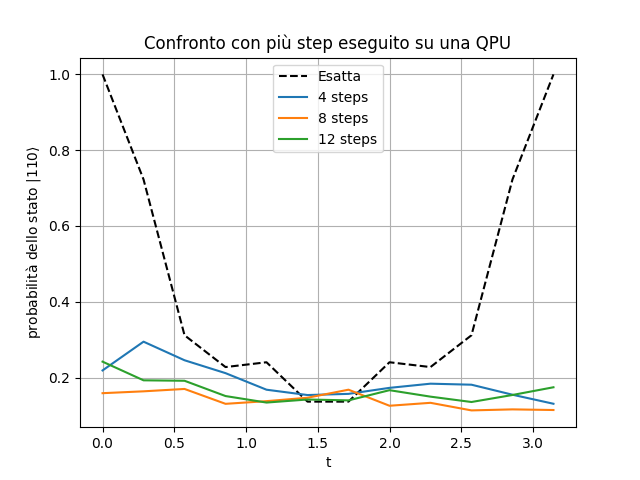

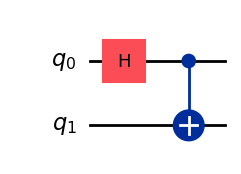

In [17]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.draw(output='mpl', filename='../circuit_drawing/bell_state.png')